# Lab 4
## More Data Scraping and EDA

In this lab, you will improve your skills in scraping data from web pages, organizing the data in a desired format, and performing EDA.

For this lab, we are reusing code from Harvard's CS109: https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb

## Lab3.A. Run code for scraping Indeed.com data

You firs task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

In [1]:
import urllib2
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import socket
import re
import requests
import json

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [3]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

C:\Users\Hoang\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\Hoang\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

The page display the search on keyword "data science" on indeed.com. There are around 13 results each page. There is an ad on the right hand side, and there are some sorting values on the left hand side. 

Meaning of url: An optional query, separated from the preceding part by a question mark (?), containing a query string of non-hierarchical data. The & is how you string together additional information.

q for job title/company and l for job location

In [4]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-2]
print("Search yielded %s hits." % (job_count_string))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print job_count

Search yielded 24,489 hits.
24489


** Question 2**:
* What does the "find(id = 'searchCount')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page

The following piece of code allows you to find the links to all the job ads on the page.

#Question 2

find(id = 'searchCount') means find the first value with the id = 'searchCount'. The second line split the string value into a list using white space as separator, and then it take the second to last element of the list: this is the string that display the number of jobs searched

In [5]:
#question 3
bs_tree.find(id = 'rb_Salary Estimate').contents

[u'\n',
 <div class="rbHeader">\n<span aria-level="3" class="ws_bold" role="heading">\n                    Salary Estimate</span>\n</div>,
 u'\n',
 <div class="rbsrbo" id="SALARY_rbo">\n<ul class="rbList">\n<li onmousedown="rbptk('rb', 'salest', '1');">\n<a href="/q-data-scientist-$55,000-jobs.html" rel="nofollow" title="$55,000 (19775)">$55,000</a> (19775)</li>\n<li onmousedown="rbptk('rb', 'salest', '2');">\n<a href="/q-data-scientist-$75,000-jobs.html" rel="nofollow" title="$75,000 (15757)">$75,000</a> (15757)</li>\n<li onmousedown="rbptk('rb', 'salest', '3');">\n<a href="/q-data-scientist-$95,000-jobs.html" rel="nofollow" title="$95,000 (11549)">$95,000</a> (11549)</li>\n<li onmousedown="rbptk('rb', 'salest', '4');">\n<a href="/q-data-scientist-$110,000-jobs.html" rel="nofollow" title="$110,000 (8087)">$110,000</a> (8087)</li>\n<li onmousedown="rbptk('rb', 'salest', '5');">\n<a href="/q-data-scientist-$130,000-jobs.html" rel="nofollow" title="$130,000 (4159)">$130,000</a> (4159)</l

In [6]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(1): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
    
    time.sleep(1)

print "We found a lot of jobs: ", len(job_links)

We found a lot of jobs:  12


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

#Question 4

the url in the first line is the original url of indeed.com. We want to store the origin url so that we can append further information and querry into the original url to reach the page we want. When i = 3, we will be on page 4. 

the command bs_tree.find(id = 'resultsCol') find the first value with the id 'resultsCol'

job_postings is a list of strings that contain div tag. For each jp in job_postings, we get the class of that block, which will return a list of string(s), and we use ''.join(jp.get('class')) to join all the string(s) inside. 

job_links is a list that contains strings of urls of each job posting that we see in the page we scrape. 

In [14]:
#question 5
#num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []

for i in range(2): #since we want 200 jobs, we need to scrape 17 pages
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = requests.get(url)
    bs_tree = bs4.BeautifulSoup(html_page.text, 'html.parser')
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll('div')
    job_postings = [jp for jp in job_postings if jp.get('class') and ''.join(jp.get('class')) == 'rowresult']
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    for i in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + i)
    
    time.sleep(1)        

print "We found a lot of jobs: ", len(job_links)

We found a lot of jobs:  26


In [8]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
            
#     if counter % 5 == 0:
#         print len(job_links) - counter
#         print skill_set
            
print skill_set

HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
{'visualization': 54, 'spark': 42, 'mapreduce': 4}


** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

re.sub(pattern,repl,string): will return the string obtained by replacing the leftmost non-overlapping occurences with the pattern in string by the replacement repl. If the pattern isn't found, the string is returned unchanged. 

[^a-z.+3] means "match from the start of the string, all characters, except the newline; +3 allows for up to 3 repetitions of the preceding. In the code above, re.sub replace everything in the html_page except this pattern by a whitespace 

skill_set is a dictionary with the skills we want to look for as keys and the number of appearance of each of them as value

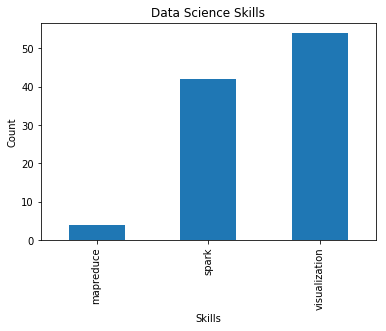

In [9]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=False)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

## Lab 3.B: Data analysis of job skills
In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills. In this part of the lab we are asking you to create pandas `DataFrame` object as a table whose rows correspond to individual ads and columns correspond to important information about the ads and skills mentioned on those pages. Let us call the table `job_ads`. Process the first 1,000 data science ads, so your table should have 1,000 rows. For each ad, you will have to create the following columns:
- job title
- company name
- job location
- skill 1
- skill 2
- ...
- skill 20

Job title, company name, and job locations will be readable from the Indeed.com page. We are asking you to list 20 skills, instead of only 3 in the code above ('mapreduce', 'spark', 'visualization'). You will need to find another 17 words that are commonly used in data science job ads. To do it, please explore the content of at least 10 ads.

Once you creat your `job_ads` table, please preform EDA of the table, in a similar way you did in Lab 2: provide code and a 2-page document that summarizes interesitng insights about the first 1,000 data science jobs.

**Deliverables**:
- the modified Lab 4 .ipynb file that contains all the answers to the questions
- a 2-page documents presenting the results of your EDA of the `job_ads` data

In [15]:
#do not rerun unless needed!
base_url = 'http://www.indeed.com'
job_links = []
jobs_list = []

for i in range(100): #since we want 1000 jobs, we need to scrape 90 pages - around 12 or 13 jobs per page
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    try:
        html_page = requests.get(url)
        bs_tree = bs4.BeautifulSoup(html_page.text, 'html.parser')
        job_link_area = bs_tree.find(id = 'resultsCol')
        job_postings = job_link_area.findAll('div')
        job_postings = [jp for jp in job_postings if jp.get('class') and ''.join(jp.get('class')) == 'rowresult']
        job_ids = [jp.get('data-jk') for jp in job_postings]
        titles = [jp.find(class_='jobtitle').text.strip() for jp in job_postings]
        companies = [jp.find(class_='company').text.strip() for jp in job_postings]
        locations = [jp.find(class_='location').text.strip() for jp in job_postings]
    except:
        print("Connection refused by server...")
        print("let\'s sleep for 5 seconds...")
        time.sleep(5)
        print("Nice!")
    
    for i in range(len(job_ids)):
        information = {"job title": titles[i], "company": companies[i], "job location": locations[i], "machine learning": 0,
                       "deep learning": 0, "neural network": 0, "nlp": 0, "natural language processing": 0, "big data": 0,                       "visualization": 0, "database": 0, "data structures": 0, "strong programming skill": 0, "algorithm": 0,\
                       "python": 0, "c++": 0, " java ": 0, "matlab": 0, " r ": 0, "tensorflow": 0, "caffe": 0, "pytorch": 0,
                       "sql": 0, "mongodb": 0, "hadoop": 0, "hive": 0, "spark": 0, "mapreduce": 0, "javascript": 0,
                       "mathematics": 0, "computer science": 0, "statistics": 0, "phd": 0, "bachelor": 0, "master": 0}
        #information['job title'] = titles[i]
        #information['company'] = companies[i]
        #information['job location'] = locations[i]
        jobs_list.append(information)
        job_links.append(base_url + '/rc/clk?jk=' + job_ids[i])
    
    time.sleep(1)        

print "We found a lot of jobs: ", len(job_links)

Connection refused by server...
let's sleep for 5 seconds...


KeyboardInterrupt: 

In [3]:
import json
with open("job_links_2.json","w") as fd:
    json.dump(job_links, fd)
del job_links

In [4]:
with open("job_links_2.json") as json_file:
    job_links = json.load(json_file)
job_links

[u'http://www.indeed.com/rc/clk?jk=9620b9780a6f0f15',
 u'http://www.indeed.com/rc/clk?jk=40642ede2fe33a42',
 u'http://www.indeed.com/rc/clk?jk=92b0adfd0e652059',
 u'http://www.indeed.com/rc/clk?jk=9abec8c23bcd21f7',
 u'http://www.indeed.com/rc/clk?jk=60a06343d151e96e',
 u'http://www.indeed.com/rc/clk?jk=d3db5c3015779bc7',
 u'http://www.indeed.com/rc/clk?jk=f3c643d319a5223d',
 u'http://www.indeed.com/rc/clk?jk=088a12f195166820',
 u'http://www.indeed.com/rc/clk?jk=f431f2674f6964eb',
 u'http://www.indeed.com/rc/clk?jk=7823ea137e68e0d7',
 u'http://www.indeed.com/rc/clk?jk=e52287bf8b1ad63e',
 u'http://www.indeed.com/rc/clk?jk=552f277e352b2be6',
 u'http://www.indeed.com/rc/clk?jk=8e58b7c7c537fefe',
 u'http://www.indeed.com/rc/clk?jk=40642ede2fe33a42',
 u'http://www.indeed.com/rc/clk?jk=8e58b7c7c537fefe',
 u'http://www.indeed.com/rc/clk?jk=bfcc46f6bbdfc912',
 u'http://www.indeed.com/rc/clk?jk=b12d494b95417cc3',
 u'http://www.indeed.com/rc/clk?jk=3da4feede99025f8',
 u'http://www.indeed.com/rc/

In [5]:
with open("jobs_list_2.json","w") as fd:
    json.dump(jobs_list, fd)
del jobs_list

In [6]:
with open("jobs_list_2.json") as json_file:
    jobs_list = json.load(json_file)
jobs_list

[{u' java ': 0,
  u' r ': 0,
  u'algorithm': 0,
  u'bachelor': 0,
  u'company': u'Bartech Group',
  u'computer science': 0,
  u'data structures': 0,
  u'database': 0,
  u'deep learning': 0,
  u'git': 0,
  u'hadoop': 0,
  u'hive': 0,
  u'job location': u'Dearborn, MI',
  u'job title': u'Data Scientists',
  u'machine learning': 0,
  u'mapreduce': 0,
  u'master': 0,
  u'mathematics': 0,
  u'matlab': 0,
  u'mongodb': 0,
  u'neural networks': 0,
  u'phd': 0,
  u'python': 0,
  u'sas': 0,
  u'spark': 0,
  u'sql': 0,
  u'stata': 0,
  u'statistics': 0,
  u'tableau': 0,
  u'tensorflow': 0,
  u'visualization': 0},
 {u' java ': 0,
  u' r ': 0,
  u'algorithm': 0,
  u'bachelor': 0,
  u'company': u'Novozymes',
  u'computer science': 0,
  u'data structures': 0,
  u'database': 0,
  u'deep learning': 0,
  u'git': 0,
  u'hadoop': 0,
  u'hive': 0,
  u'job location': u'Research Triangle Park, NC',
  u'job title': u'Data Scientist Department: Quality, Environmental and Health...',
  u'machine learning': 0,


In [4]:
len(job_links), len(jobs_list)

(1240, 1240)

In [ ]:
import string

In [7]:
counter = 0
jobs_data= []
for i in range(len(job_links)):
    counter +=1
    url = job_links[i]
    print counter

    try:
        r = requests.get(url)
        if r.status_code == 200:
            html_page = r.text
            soup = bs4.BeautifulSoup(html_page)
#             print soup
            for s in soup(["script", "style"]):
                s.extract() # rip it out

            # get text
            text = soup.get_text()

            # break into lines and remove leading and trailing space on each
            lines = (line.strip() for line in text.splitlines())
            # break multi-headlines into a line each
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            # drop blank lines
            text = '\n'.join(chunk for chunk in chunks if chunk)
            text = re.sub(r'[^\w\s]','',text)
            post = jobs_list[i].copy()
#             text_list = [re.sub('\W+', '', w) for w in text.lower().split()]
            for key in post.keys():
                if type(post[key]) == int and key in text.lower():                        
                    post[key] +=1
#                 elif type(post[key]) == int and len(key) > 1:
#                     if key in text.lower():
#                         post[key] += 1
            jobs_data.append(post)
        else:
            print 'URLError'
            continue
    except:
        print 'HTTPError'
        continue

print jobs_data[:5]

1


C:\Users\Hoang\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\Hoang\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


2
3
4
5
6
7
8
9
10
11
HTTPError
12
13
14
15
16
17
18
19
20


C:\Users\Hoang\Anaconda2\lib\site-packages\urllib3\connection.py:344: SubjectAltNameWarning: Certificate for jobs.hr.upenn.edu has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning


HTTPError
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
URLError
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
HTTPError
180
181
182
183
184
185
186
187
188
189
190
191
192
URLError
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216


C:\Users\Hoang\Anaconda2\lib\site-packages\urllib3\connection.py:344: SubjectAltNameWarning: Certificate for jobs.ccp.edu has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning


HTTPError
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
URLError
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
URLError
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431


C:\Users\Hoang\Anaconda2\lib\site-packages\urllib3\connection.py:344: SubjectAltNameWarning: Certificate for employment.unl.edu has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning


HTTPError
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
URLError
463
464
465
466
467
468
469
470
471
472
473
474
URLError
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
URLError
503
504
505
506
507
URLError
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
HTTPError
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
URLError
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
URLError
576
577
578
579
580
581
582
583
584
URLError
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
HTTPError
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
HTTPError
655
6

C:\Users\Hoang\Anaconda2\lib\site-packages\urllib3\connection.py:344: SubjectAltNameWarning: Certificate for jobs.utdallas.edu has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning


1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096


C:\Users\Hoang\Anaconda2\lib\site-packages\urllib3\connection.py:344: SubjectAltNameWarning: Certificate for www.pittsource.com has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning


HTTPError
1097
URLError
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
URLError
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
URLError
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
128

In [8]:
with open("jobs_data_2.json","w") as fd:
    json.dump(jobs_data, fd)

In [9]:
del jobs_data

In [10]:
with open("jobs_data_2.json") as json_file:
    jobs_data = json.load(json_file)

In [11]:
jobs_data[:5]

[{u' java ': 0,
  u' r ': 0,
  u'algorithm': 1,
  u'bachelor': 1,
  u'company': u'Bartech Group',
  u'computer science': 0,
  u'data structures': 0,
  u'database': 0,
  u'deep learning': 0,
  u'git': 0,
  u'hadoop': 1,
  u'hive': 0,
  u'job location': u'Dearborn, MI',
  u'job title': u'Data Scientists',
  u'machine learning': 0,
  u'mapreduce': 0,
  u'master': 1,
  u'mathematics': 1,
  u'matlab': 0,
  u'mongodb': 0,
  u'neural networks': 0,
  u'phd': 0,
  u'python': 0,
  u'sas': 1,
  u'spark': 1,
  u'sql': 1,
  u'stata': 0,
  u'statistics': 1,
  u'tableau': 0,
  u'tensorflow': 0,
  u'visualization': 0},
 {u' java ': 0,
  u' r ': 0,
  u'algorithm': 0,
  u'bachelor': 0,
  u'company': u'Novozymes',
  u'computer science': 0,
  u'data structures': 0,
  u'database': 0,
  u'deep learning': 0,
  u'git': 0,
  u'hadoop': 0,
  u'hive': 0,
  u'job location': u'Research Triangle Park, NC',
  u'job title': u'Data Scientist Department: Quality, Environmental and Health...',
  u'machine learning': 0,


In [16]:
df = pd.DataFrame(jobs_data)
df = df[['job title','company', 'job location', 'machine learning', 'python', 'deep learning', 'neural networks', 'tensorflow', 
         ' r ', 'sas', 'matlab', 'stata', 'visualization', 'tableau', 'algorithm', ' java ', 'database', 'sql', 'spark', 
         'mongodb','hive','git', 'hadoop', 'bachelor', 'master', 'phd', 'mathematics', 'statistics','computer science']]
df

,job title,company,job location,machine learning,python,deep learning,neural networks,tensorflow,r,sas,...,mongodb,hive,git,hadoop,bachelor,master,phd,mathematics,statistics,computer science
0,Data Scientists,Bartech Group,"Dearborn, MI",0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,1,1,0
1,"Data Scientist Department: Quality, Environmen...",Novozymes,"Research Triangle Park, NC",0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
2,Scientist II or higher,"Sekisui XenoTech, LLC","Kansas City, KS 66103",0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0
3,Data Scientist - Predictive Modeling,Carvana,"Tempe, AZ",1,1,0,0,0,1,1,...,0,0,0,1,1,0,1,0,1,1
4,Data Scientist,Penn Interactive Ventures,"Conshohocken, PA",1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
5,Data Scientist I,Children's Hospital of Philadelphia,"Philadelphia, PA 19146 (Point Breeze area)",1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
6,Data Scientist,Oath Inc,"Champaign, IL",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Data Analyst - Machine Learning,JP Morgan Chase,"Columbus, OH 43240 (Far North area)",1,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,1,1
8,Data Scientist Entry Level,Intel,"Hillsboro, OR 97124",1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
9,Data Scientist,Willis Towers Watson,"Philadelphia, PA",1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df[['machine learning', 'python', 'deep learning', 'neural networks', 'tensorflow', 
    ' r ', 'sas', 'matlab', 'stata', 'visualization', 'tableau', 'algorithm', ' java ', 'database', 'sql', 'spark', 
    'mongodb','hive','git', 'hadoop', 'bachelor', 'master', 'phd', 'mathematics', 'statistics','computer science']].sum().sort_values()

stata                15
mongodb              25
neural networks      71
tableau              97
hive                 97
tensorflow          100
deep learning       123
 java               172
git                 180
matlab              208
spark               240
database            247
hadoop              258
visualization       299
sas                 340
bachelor            369
sql                 393
computer science    395
mathematics         397
 r                  464
algorithm           476
phd                 481
machine learning    518
master              537
python              577
statistics          671
dtype: int64